
# 🧪 NLP Clínico: Comparación **spaCy** vs **NLTK** (TF‑IDF)

**Objetivo:** clonar en un notebook el comportamiento de `scripts/main.py` para:  
1) obtener un dataset pequeño de **notas clínicas**,  
2) **limpiar** el texto, **tokenizar** y **normalizar** con **spaCy** y **NLTK**,  
3) **vectorizar** con **`TfidfVectorizer`**,  
4) **visualizar** términos relevantes por documento,  
5) **comparar** corpus original vs. preprocesado (longitud media, vocabulario, repetición).

> Este notebook está pensado para ejecutarse dentro del proyecto con la estructura `src/`, `scripts/`, `configs/`, `reports/`, etc. Si lo abres en **Google Colab**, sube/clona la carpeta del proyecto y ajusta `PROJECT_ROOT` abajo.



## 0) Preparación de entorno y rutas
- Priorizamos el `src/` **del proyecto actual** (evita colisiones con otros proyectos).
- Opcionalmente, descargamos recursos de **spaCy** y **NLTK** si faltan.


In [1]:

# --- Ajusta esta ruta si ejecutas en Colab o fuera del repo ---
from pathlib import Path
PROJECT_ROOT = "/home/malezainia2/mini_projects/machine_learning_projects/Modulo8Clase2MarcoParra"

# Si ejecutas en Colab, por ejemplo:
# from google.colab import drive
# drive.mount('/content/drive')
# PROJECT_ROOT = Path('/content/drive/MyDrive/Modulo8Clase2MarcoParra').resolve()

import sys
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("sys.path[0]:", sys.path[0])


PROJECT_ROOT: /home/malezainia2/mini_projects/machine_learning_projects/Modulo8Clase2MarcoParra
sys.path[0]: /home/malezainia2/mini_projects/machine_learning_projects/Modulo8Clase2MarcoParra


In [2]:

# Recursos opcionales (ejecuta si NO tienes modelos/recursos instalados)
# Puedes comentar estas celdas si ya lo hiciste antes.

# 1) Modelos spaCy (es/en)
try:
    import spacy
    try:
        spacy.load("es_core_news_sm")
    except Exception:
        print("[setup] Descargando spaCy es_core_news_sm...")
        !python -m spacy download es_core_news_sm
    try:
        spacy.load("en_core_web_sm")
    except Exception:
        print("[setup] Descargando spaCy en_core_web_sm... (opcional)")
        !python -m spacy download en_core_web_sm
except Exception as e:
    print("spaCy no disponible en este entorno:", e)

# 2) Paquetes NLTK
try:
    import nltk
    for pkg in ["punkt","punkt_tab","stopwords","wordnet","omw-1.4"]:
        try:
            nltk.data.find("tokenizers/" + ("punkt" if pkg.startswith("punkt") else ""))
        except LookupError:
            try:
                nltk.download(pkg, quiet=True, raise_on_error=True)
                print(f"[setup] NLTK descargado: {pkg}")
            except Exception as e:
                print(f"[setup] No se pudo descargar {pkg}: {e}")
except Exception as e:
    print("NLTK no disponible en este entorno:", e)



## 1) Imports del proyecto y configuración
Leemos el YAML de configuración y preparamos rutas de salida.


In [5]:
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    
PROJECT_ROOT = Path(PROJECT_ROOT).resolve()

from src.utils.io import load_yaml, ensure_dir
from src.pipelines.run_pipeline import run
from pathlib import Path
import json, os

CFG_PATH = PROJECT_ROOT / "configs" / "config_default.yaml"
assert CFG_PATH.exists(), f"No existe el archivo de config: {CFG_PATH}"

cfg = load_yaml(CFG_PATH)
fig_dir = PROJECT_ROOT / cfg["project"]["figures_dir"]
ensure_dir(fig_dir)
print("Config OK:", CFG_PATH)


Config OK: /home/malezainia2/mini_projects/machine_learning_projects/Modulo8Clase2MarcoParra/configs/config_default.yaml



## 2) Ejecutar el pipeline completo (clon de `scripts/main.py`)
Esto:
- Obtiene el dataset (descarga o sintético),
- Limpia, tokeniza y normaliza con **spaCy** y **NLTK**,
- Vectoriza con **TF‑IDF**,
- Genera **gráficos** por documento,
- Calcula **métricas** y las guarda en `reports/metrics.json`.


In [6]:

metrics = run(str(CFG_PATH))
metrics


{'spacy': {'original': {'docs': 10,
   'mean_length': 9.8,
   'vocab_size': 77,
   'mean_repetition_ratio': 0.018181818181818188},
  'processed': {'docs': 10,
   'mean_length': 7.4,
   'vocab_size': 63,
   'mean_repetition_ratio': 0.0}},
 'nltk': {'original': {'docs': 10,
   'mean_length': 9.8,
   'vocab_size': 77,
   'mean_repetition_ratio': 0.018181818181818188},
  'processed': {'docs': 10,
   'mean_length': 7.6,
   'vocab_size': 65,
   'mean_repetition_ratio': 0.0}}}


## 3) Métricas: original vs. preprocesado
Mostramos un resumen amigable de las métricas guardadas.


In [7]:

import pandas as pd

# Estructuramos el dict de métricas en un DataFrame
rows = []
for engine in ["spacy", "nltk"]:
    for split in ["original","processed"]:
        m = metrics[engine][split]
        rows.append({
            "engine": engine,
            "split": split,
            "docs": m["docs"],
            "mean_length": m["mean_length"],
            "vocab_size": m["vocab_size"],
            "mean_repetition_ratio": m["mean_repetition_ratio"],
        })
dfm = pd.DataFrame(rows)
dfm


,engine,split,docs,mean_length,vocab_size,mean_repetition_ratio
0,spacy,original,10,9.8,77,0.018182
1,spacy,processed,10,7.4,63,0.000000
2,nltk,original,10,9.8,77,0.018182
3,nltk,processed,10,7.6,65,0.000000



## 4) Galería de gráficos TF‑IDF (NLTK vs. spaCy)
Se cargan las figuras generadas por el pipeline desde `reports/figures/` y se muestran **lado a lado** para cada documento.


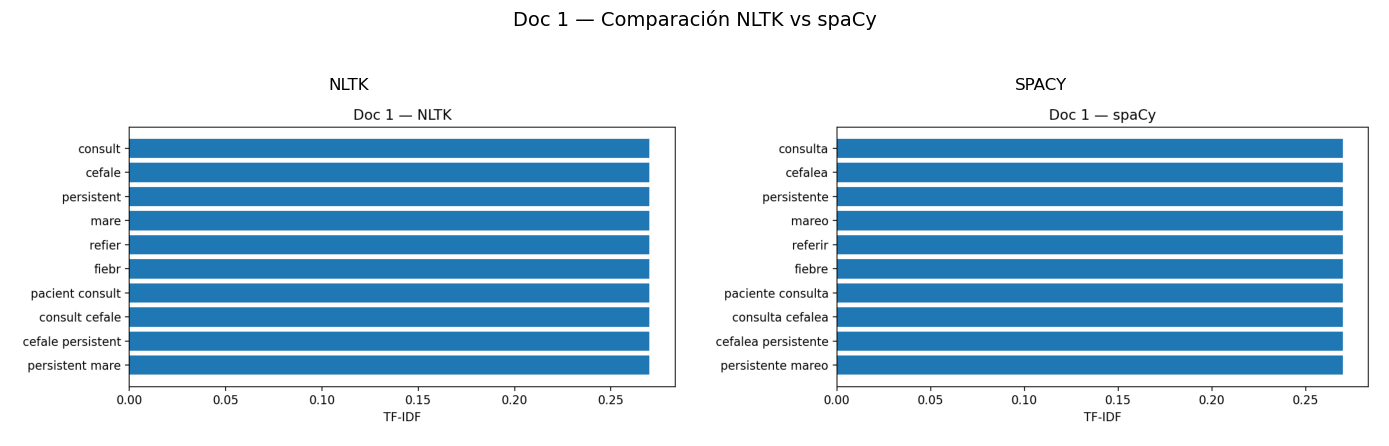

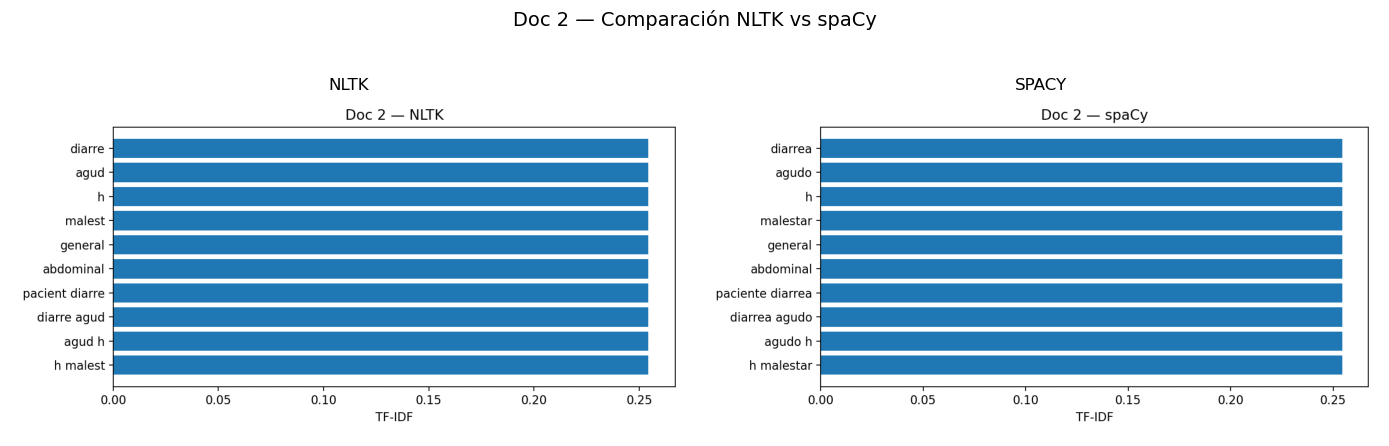

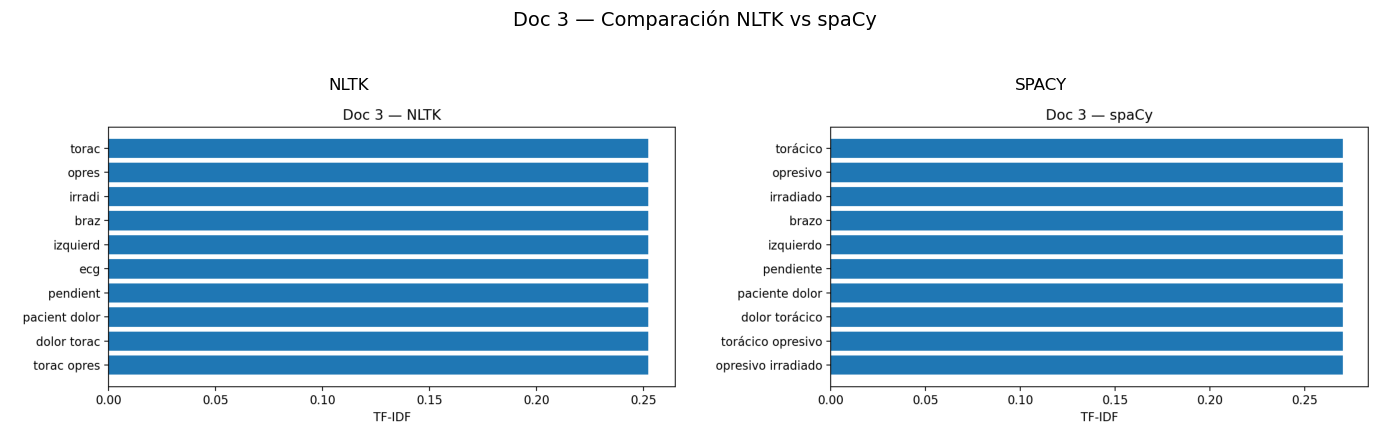

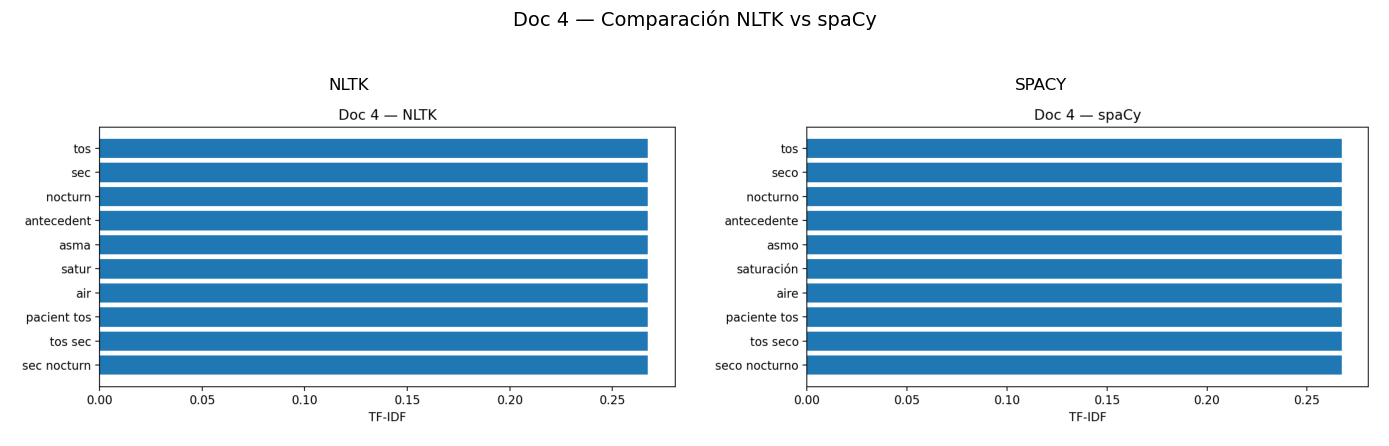

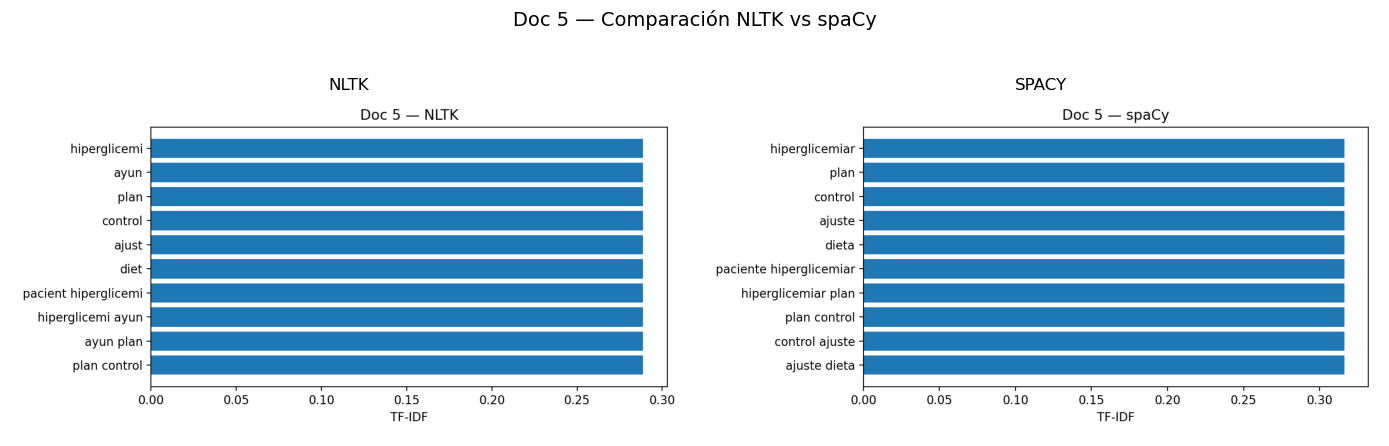

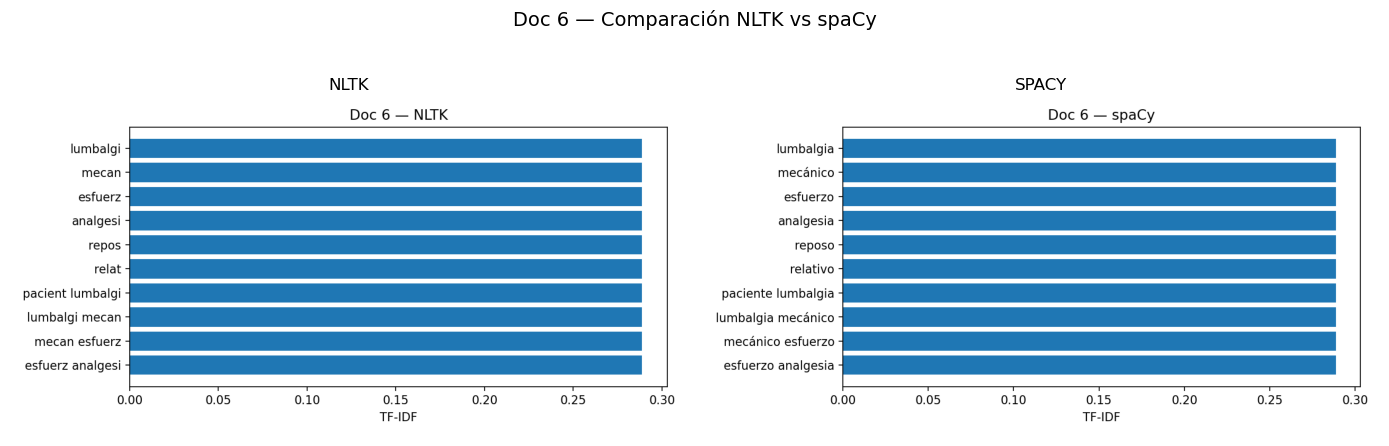

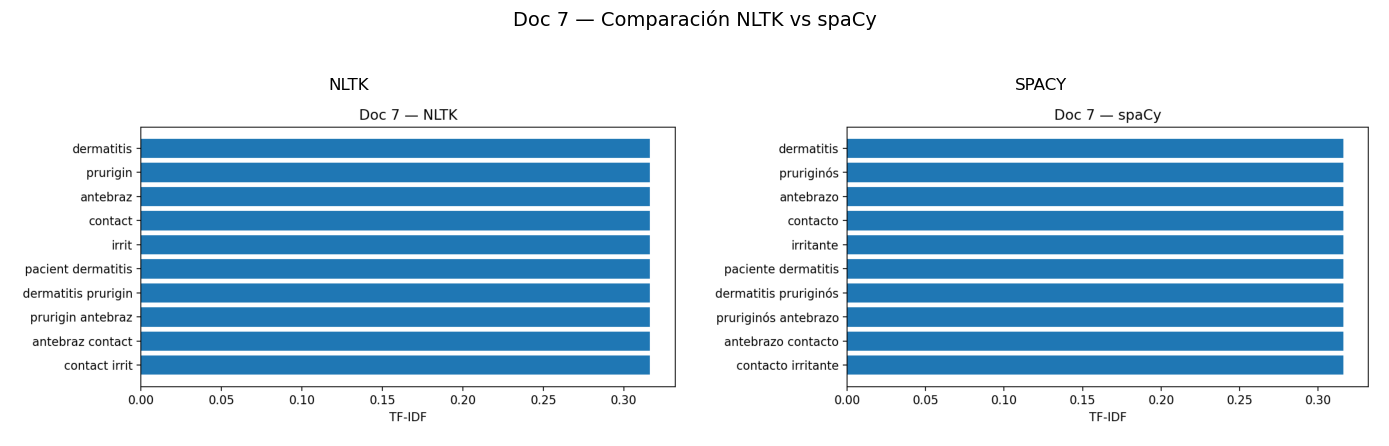

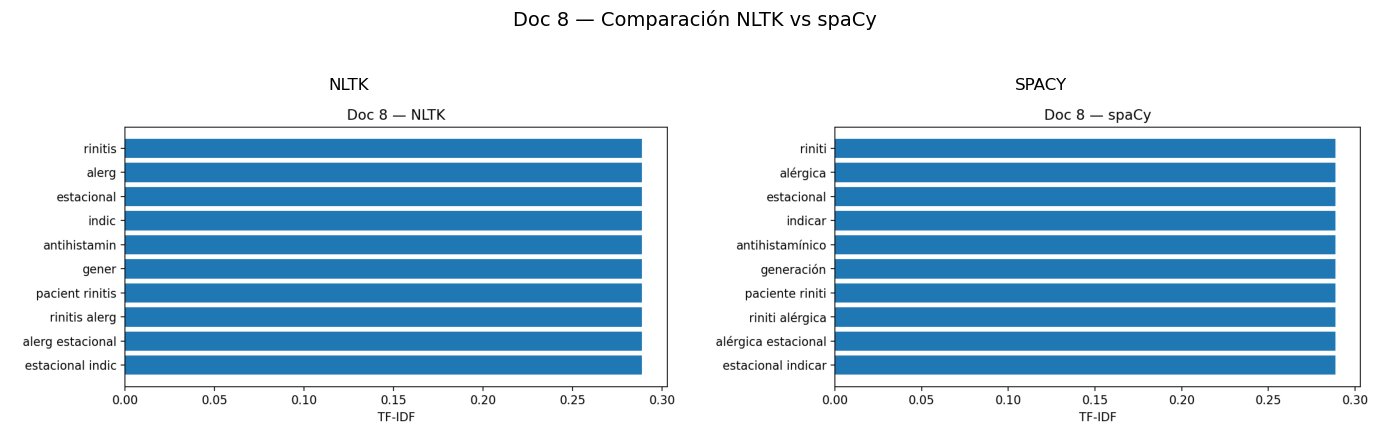

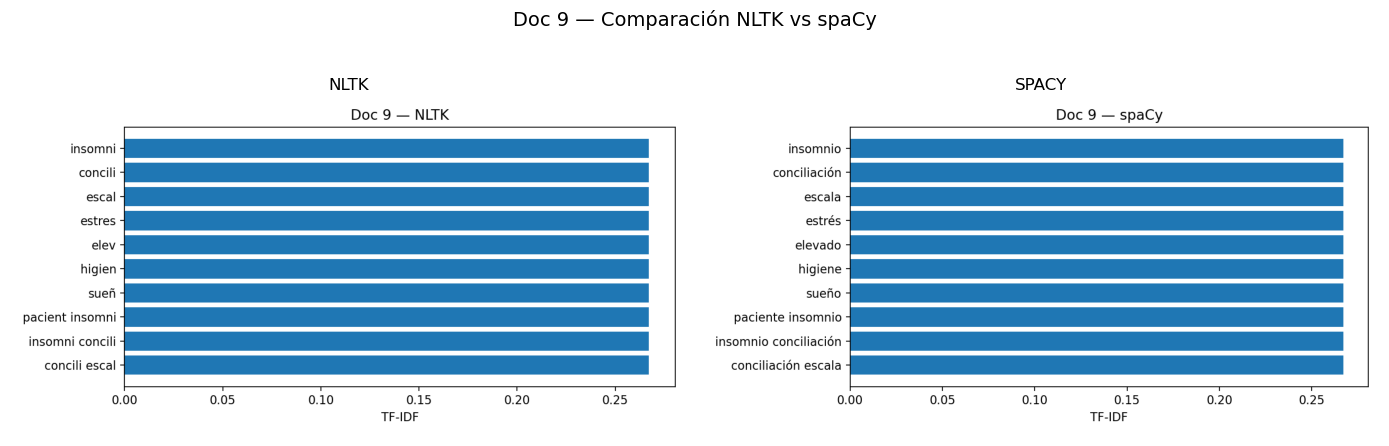

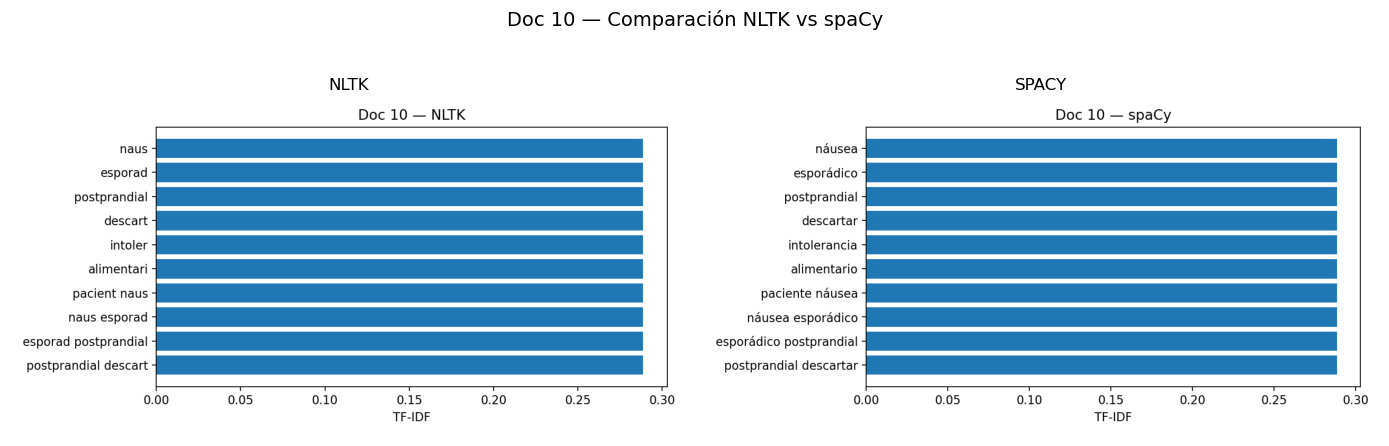

In [8]:

import matplotlib.pyplot as plt
from pathlib import Path
import re

figs = sorted([p for p in fig_dir.glob("doc_*_*.png")])
# Agrupar por doc: doc_01_nltk.png + doc_01_spacy.png, etc.
pairs = {}
for p in figs:
    m = re.match(r"doc_(\d+)_([a-z]+)\.png", p.name)
    if not m:
        # Intenta patrón alternativo doc_01_spacy.png etc ya cubierto
        m = re.match(r"doc_(\d+)_(\w+)\.png", p.name)
    if not m:
        continue
    idx, engine = m.group(1), m.group(2).lower()
    pairs.setdefault(idx, {})[engine] = p

# Mostrar en orden
for idx in sorted(pairs.keys()):
    group = pairs[idx]
    if not group:
        continue
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"Doc {int(idx)} — Comparación NLTK vs spaCy", fontsize=14)
    # NLTK a la izquierda, spaCy a la derecha (si existen)
    for j, engine in enumerate(["nltk", "spacy"]):
        ax = axes[j]
        if engine in group:
            img = plt.imread(group[engine])
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(engine.upper())
        else:
            ax.axis("off")
            ax.set_title(engine.upper() + " (no disponible)")
    plt.tight_layout()
    plt.show()



## 5) Discusión rápida

- **NLTK (stemming)** = tokens más cortos (raíces), menor legibilidad clínica pero útil para reducir el espacio de características.
- **spaCy (lematización)** = tokens completos con tildes, mayor interpretabilidad y reportabilidad.
- Ambos reducen **longitud media** y **vocabulario** respecto al original; **spaCy** tiende a normalizar mejor en español.
- Para tareas de **clasificación/agrupación**, cualquiera funciona; para informes clínicos y trazabilidad de términos, **spaCy** suele ser preferible.



## 6) Reproducibilidad
- Configuración centralizada en `configs/config_default.yaml`.
- Artefactos en `reports/` y `data/processed/`.
- Para cambiar idioma o fuentes de stopwords, edita la sección `preprocessing` (e.g., `language`, `stopwords_source`).
